### Monte Carlo Simulation of Profitability Likelihood

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('inputprice.csv')
df2 = pd.read_csv('Linear Low Density Polyethylene Futures Historical Data.csv')
df2

,Date,Price,Open,High,Low,Vol.,Change %
0,14-Aug-22,7669.0,7840.0,7987.0,7592.0,134.07K,-0.05
1,7-Aug-22,8098.0,7808.0,7808.0,7808.0,0.06K,0.04
2,31-Jul-22,7784.0,8666.0,8666.0,8010.0,0.16K,-0.03
3,24-Jul-22,8064.0,7673.0,8212.0,7673.0,4.14K,0.05
4,17-Jul-22,7673.0,7655.0,8009.0,7540.0,1.41K,-0.01
...,...,...,...,...,...,...,...
540,5-Feb-12,9710.0,9745.0,9835.0,9710.0,0.33K,0.00
541,29-Jan-12,9755.0,9680.0,9845.0,9680.0,0.48K,0.02
542,15-Jan-12,9540.0,9190.0,9675.0,9100.0,3.44K,0.03
543,8-Jan-12,9235.0,9250.0,9365.0,9205.0,5.01K,0.00


In [3]:
df1['HDPE/brick'] = df1['HDPE price per kg'] * 0.1111
df1['Sand/brick'] = df1['Sand price per kg'] * 0.4444

hdpe_mean = df1['HDPE/brick'].mean()
sand_mean = df1['Sand/brick'].mean()

In [4]:
price_change = np.log(1+df2['Price'].pct_change())

In [5]:
price_change

0           NaN
1      0.054431
2     -0.039547
3      0.035339
4     -0.049702
         ...   
540    0.001030
541    0.004624
542   -0.022286
543   -0.032493
544    0.000000
Name: Price, Length: 545, dtype: float64

In [6]:
mu, sigma = price_change.mean(), price_change.std()

In [24]:
brickprice = 10
benchmark = 3
brick_priceinflation = 0.05

In [8]:
sim_price = np.random.normal(mu, sigma, 260)
sim_inflation = np.random.normal(0.0574/52, 0.0249/52, 260)
sim_brickinf = np.random.normal(brick_priceinflation/52, 0, 260) #forgot how to fill an array 

In [9]:
net = (brickprice*(sim_brickinf + 1).cumprod()) - ((sand_mean*(sim_inflation + 1).cumprod()) + ((hdpe_mean)*(sim_price + 1).cumprod()))

In [43]:
(brickprice*(sim_brickinf + 1).cumprod())

array([10.00961538, 10.01924001, 10.0288739 , 10.03851705, 10.04816947,
       10.05783117, 10.06750216, 10.07718245, 10.08687205, 10.09657097,
       10.10627921, 10.11599678, 10.1257237 , 10.13545998, 10.14520561,
       10.15496062, 10.164725  , 10.17449877, 10.18428195, 10.19407453,
       10.20387652, 10.21368794, 10.22350879, 10.23333909, 10.24317884,
       10.25302805, 10.26288673, 10.27275489, 10.28263254, 10.29251969,
       10.30241634, 10.31232251, 10.3222382 , 10.33216343, 10.34209821,
       10.35204253, 10.36199642, 10.37195988, 10.38193291, 10.39191554,
       10.40190777, 10.4119096 , 10.42192105, 10.43194213, 10.44197285,
       10.45201321, 10.46206322, 10.47212289, 10.48219224, 10.49227127,
       10.50236   , 10.51245842, 10.52256655, 10.5326844 , 10.54281199,
       10.55294931, 10.56309637, 10.5732532 , 10.58341978, 10.59359615,
       10.6037823 , 10.61397824, 10.62418399, 10.63439955, 10.64462494,
       10.65486016, 10.66510521, 10.67536012, 10.68562489, 10.69

In [35]:
num_simulations = 1000

yr1_profit = []
yr2_profit = []
yr3_profit = []
yr4_profit = []
yr5_profit = []

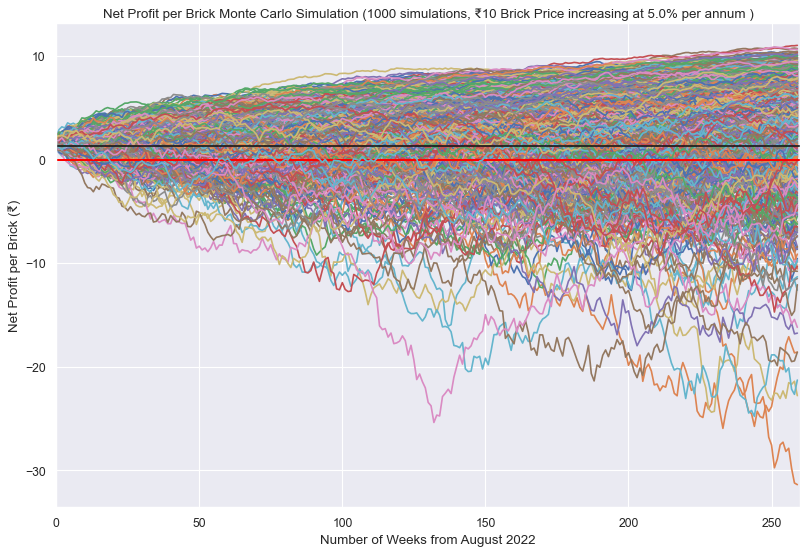

In [36]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(num_simulations):
    sim_price = np.random.normal(mu, sigma, 260)
    sim_inflation = np.random.normal(0.0574/52, 0.0249/52, 260)
    net = (brickprice*(sim_inflation + 1).cumprod()) - ((sand_mean*(sim_inflation + 1).cumprod()) + ((hdpe_mean)*(sim_price + 1).cumprod()))
    
    yr1_profit.append(net[51])
    yr2_profit.append(net[103])
    yr3_profit.append(net[155])
    yr4_profit.append(net[207])
    yr5_profit.append(net[259])
    

    plt.axhline(0, c='red')
    plt.title("Net Profit per Brick Monte Carlo Simulation (" + str(num_simulations) + " simulations, ₹10 Brick Price increasing at " + str(brick_priceinflation*100) + "% per annum )")
    plt.xlabel("Number of Weeks from August 2022")
    plt.ylabel("Net Profit per Brick (₹)")
    plt.xlim([0, 260])
    plt.plot(net)
    
plt.axhline(net[0], c='k') #print outside loop or too many lines

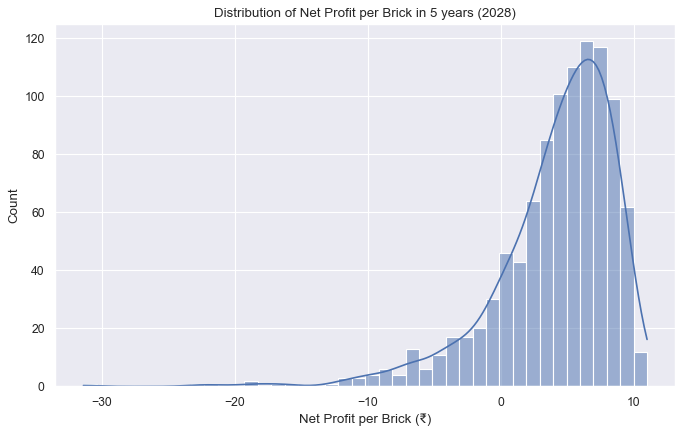

In [37]:
import seaborn as sns

plt.figure(figsize=(10, 6), dpi=80)
sns.set(style="darkgrid")
sns.histplot(yr5_profit, kde=True)
plt.title("Distribution of Net Profit per Brick in 5 years (2028)")
plt.xlabel("Net Profit per Brick (₹)")
plt.show()

In [38]:
from statistics import median
prob1 = (sum(x > 0 for x in yr1_profit)/len(yr1_profit))*100
prob2 = (sum(x > 0 for x in yr2_profit)/len(yr2_profit))*100
prob3 = (sum(x > 0 for x in yr3_profit)/len(yr3_profit))*100
prob4 = (sum(x > 0 for x in yr4_profit)/len(yr4_profit))*100
prob5 = (sum(x > 0 for x in yr5_profit)/len(yr5_profit))*100

In [39]:
print("Increasing the brick price by " + str(brick_priceinflation*100) + "% per year, the probability of profit is:")
print("Year 1: " + str(prob1) + "%")
print("Year 2: " + str(prob2) + "%")
print("Year 3: " + str(prob3) + "%")
print("Year 4: " + str(prob4) + "%")
print("Year 5: " + str(prob5) + "%")

Increasing the brick price by 5.0% per year, the probability of profit is:
Year 1: 87.2%
Year 2: 84.5%
Year 3: 85.6%
Year 4: 84.3%
Year 5: 85.5%


In [40]:
prob1a = (sum(x > benchmark for x in yr1_profit)/len(yr1_profit))*100
prob2a = (sum(x > benchmark for x in yr2_profit)/len(yr2_profit))*100
prob3a = (sum(x > benchmark for x in yr3_profit)/len(yr3_profit))*100
prob4a = (sum(x > benchmark for x in yr4_profit)/len(yr4_profit))*100
prob5a = (sum(x > benchmark for x in yr5_profit)/len(yr5_profit))*100

In [41]:
print("Increasing the brick price by " + str(brick_priceinflation*100) + "% per year, the probability of profit above benchmark is:")
print("Year 1: " + str(prob1a) + "%")
print("Year 2: " + str(prob2a) + "%")
print("Year 3: " + str(prob3a) + "%")
print("Year 4: " + str(prob4a) + "%")
print("Year 5: " + str(prob5a) + "%")

Increasing the brick price by 5.0% per year, the probability of profit above benchmark is:
Year 1: 36.3%
Year 2: 49.7%
Year 3: 59.9%
Year 4: 63.9%
Year 5: 70.1%


In [42]:
print("Most likely profit per brick in:")
print("Year 1: $" + str(median(yr1_profit)))
print("Year 2: $" + str(median(yr2_profit)))
print("Year 3: $" + str(median(yr3_profit)))
print("Year 4: $" + str(median(yr4_profit)))
print("Year 5: $" + str(median(yr5_profit)))

Most likely profit per brick in:
Year 1: $2.368228046141299
Year 2: $2.986746610788585
Year 3: $3.735504839852057
Year 4: $4.466855775165546
Year 5: $5.135336325462963
